<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/inceptionv3/Notebooks/transfer_learning_fine_tunning(voets_partition_server).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Environment set up

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-b33d193e-a4bb-94bd-0a58-a0ae330b73b0)


The last line with Util 0% is what you should look for

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 10.7 GB  | Proc size: 4.1 GB
GPU RAM Free: 1080MB | Used: 6531MB | Util  86% | Total 7611MB


In [ ]:
#!kill -9 -1

Mount Google Drive

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
auth.authenticate_user()

In [ ]:
root_path = 'drive/My Drive/Project'

------------

# 1. Experimentation 

In [ ]:
import os
import zipfile
import itertools
import numpy as np
import h5py
import random
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import InceptionV3 
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    GlobalMaxPool1D,
    MaxPooling2D,
    Conv2D,
    BatchNormalization,
    Flatten,
    Dropout,
    Concatenate,
    Activation,
    Bidirectional,
)

from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print(f"Numpy version: {np.__version__}")
print(f"Tensorflow version: {tf.__version__}")

random.seed(432)

Numpy version: 1.18.5
Tensorflow version: 2.2.0


In [ ]:
# Parameters 
BATCH_SIZE = 32
num_workers = 8
num_epochs = 200
learning_rate = 1e-6
decay = 4e-5
min_delta_auc = 0.01
img_width, img_height = 299, 299

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
  except RuntimeError as e:
    print(e)

#### Download data

In [ ]:
!gdown https://drive.google.com/uc?id=1Y0pDtx-5HdDcXFWyp2Kcjc4DCG65VLAH

Downloading...
From: https://drive.google.com/uc?id=1Y0pDtx-5HdDcXFWyp2Kcjc4DCG65VLAH
To: /content/eyepacs.zip
4.79GB [01:30, 52.9MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p

Downloading...
From: https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p
To: /content/messidor2.zip
106MB [00:00, 110MB/s] 


In [ ]:
local_zip = '/content/eyepacs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
local_zip = '/content/messidor2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
# Train data 
train_dir_1 = os.path.join('/content/eyepacs/train/1')
train_dir_0 = os.path.join('/content/eyepacs/train/0')

print("Total imagenes training Diabetic Retinopathy:", len(os.listdir(train_dir_1)))
print(
    "Total imagenes training Non Diabetic Retinopathy:",
    len(os.listdir(train_dir_0)),
)

Total imagenes training Diabetic Retinopathy: 16139
Total imagenes training Non Diabetic Retinopathy: 40688


In [ ]:
# Test data 
test_dir_1 = os.path.join('/content/eyepacs/test/1')
test_dir_0 = os.path.join('/content/eyepacs/test/0')

print("Total imagenes Test Diabetic Retinopathy:", len(os.listdir(test_dir_1)))
print(
    "Total imagenes Test Non Diabetic Retinopathy:",
    len(os.listdir(test_dir_0)),
)

Total imagenes Test Diabetic Retinopathy: 694
Total imagenes Test Non Diabetic Retinopathy: 8096


In [ ]:
dr_files = os.listdir(train_dir_1)
no_dr_files = os.listdir(train_dir_0)

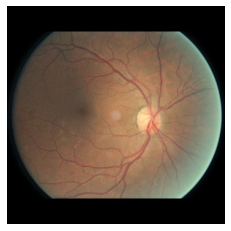

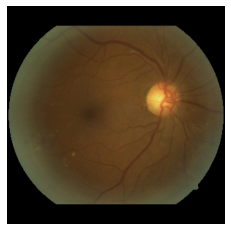

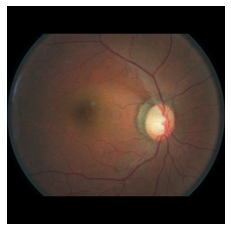

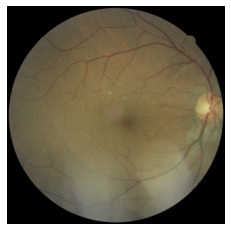

In [ ]:
pic_index = 2

next_dr = [os.path.join(train_dir_1, fname) for fname in dr_files[pic_index - 2 : pic_index]]
next_no_dr = [
    os.path.join(train_dir_0, fname) for fname in no_dr_files[pic_index - 2 : pic_index]
]

for i, img_path in enumerate(next_dr + next_no_dr):

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis("Off")
    plt.show()

In [ ]:
def preprocessing(image):
    image = tf.image.random_brightness(image, 0.125)
    image = tf.image.random_saturation(image, 0.5, 1.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    return image 

In [ ]:
TRAINING_DIR = "/content/eyepacs/train/"
TEST_DIR = "/content/eyepacs/test"
TEST_MESSIDOR_DIR = "/content/messidor2" 

datagen = ImageDataGenerator(
    samplewise_center=True,
    horizontal_flip=True,
    rescale=1./255,
    preprocessing_function=preprocessing,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='training',
    shuffle=True,
)

val_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='validation',
    shuffle=True,
)

Found 45463 images belonging to 2 classes.
Found 11364 images belonging to 2 classes.


In [ ]:
steps_per_epoch = train_generator.n // BATCH_SIZE
validation_steps = val_generator.n // BATCH_SIZE

In [ ]:
train_generator2 = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=1,
    class_mode="binary",
    shuffle=False,
)

Found 56827 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(samplewise_center = True, 
                                  rescale=1./255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 8790 images belonging to 2 classes.


In [ ]:
messidor_datagen = ImageDataGenerator(samplewise_center = True, 
                                      rescale=1./255)

messidor_generator = messidor_datagen.flow_from_directory(
	TEST_MESSIDOR_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 1748 images belonging to 2 classes.


-------

## 1.1 Fine tunning 

#### Warmup
First we do a warmup training only the top layers:

In [ ]:
base_model = InceptionV3(weights='imagenet', 
                   include_top=False,
                   pooling='avg',
                   input_shape=(img_width, img_height,3))

# Freeze the feature extractor
for layer in base_model.layers:
    layer.trainable=False

x = Dense(2048, activation='relu')(base_model.output)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate,
                                       decay=decay),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [ ]:
model.fit_generator(
    train_generator,
    epochs=40,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
)

Epoch 1/40
1420/1420 [==============================] - 582s 410ms/step - loss: 0.5873 - accuracy: 0.7112 - auc_1: 0.5535 - val_loss: 0.7594 - val_accuracy: 0.7160 - val_auc_1: 0.5918
Epoch 2/40
1420/1420 [==============================] - 546s 384ms/step - loss: 0.5643 - accuracy: 0.7214 - auc_1: 0.6095 - val_loss: 0.5893 - val_accuracy: 0.7158 - val_auc_1: 0.6235
Epoch 3/40
1420/1420 [==============================] - 534s 376ms/step - loss: 0.5543 - accuracy: 0.7291 - auc_1: 0.6328 - val_loss: 0.6040 - val_accuracy: 0.7162 - val_auc_1: 0.6410
Epoch 4/40
1420/1420 [==============================] - 536s 378ms/step - loss: 0.5471 - accuracy: 0.7366 - auc_1: 0.6470 - val_loss: 0.5370 - val_accuracy: 0.7151 - val_auc_1: 0.6513
Epoch 5/40
1420/1420 [==============================] - 537s 378ms/step - loss: 0.5441 - accuracy: 0.7382 - auc_1: 0.6552 - val_loss: 0.4050 - val_accuracy: 0.7173 - val_auc_1: 0.6584
Epoch 6/40
1420/1420 [==============================] - 529s 372ms/step - loss: 

In [ ]:
# Serialize model to JSON
model_json = model.to_json()
with open('{}/{}/{}'.format(root_path,"model", "InceptionV3_model_warm_up.json"), "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights('{}/{}/{}'.format(root_path, "model", "InceptionV3_model_warm_up.h5"))
print("Saved model to disk")

Saved model to disk


In [ ]:
# [OPTIONAL] Resume training from saved weigths
resume_json_file_structure = 'InceptionV3_model_warm_up.json'

# Load json file structure and create model
json_file = open('drive/My Drive/Project/model/{}'.format(resume_json_file_structure), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# Load weights into new model
resume_model_weigths = 'InceptionV3-epochs:066-val_loss:0.106.hdf5' # CHANGE THIS 
model.load_weights('drive/My Drive/Project/model/{}'.format(resume_model_weigths))
print("Loaded model from Drive")

Loaded model from Drive


#### Unfreeze the extractor layers

In [ ]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate,
                                       decay=decay),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

file_name = "InceptionV3-epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"
filepath = '{}/{}/{}'.format(root_path, "model",  file_name)

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only = True, 
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=200, 
                           verbose=1, 
                           mode='auto', 
                           baseline=None, 
                           restore_best_weights=True)

In [ ]:
# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 100, #15+13+72
    validation_data = val_generator,
    validation_steps = validation_steps,
    callbacks = [checkpoint, early_stop]
    )

Epoch 1/100
1420/1420 [==============================] - 1887s 1s/step - loss: 0.2690 - accuracy: 0.8863 - auc: 0.9394 - val_loss: 0.4148 - val_accuracy: 0.8180 - val_auc: 0.9300

Epoch 00001: val_loss improved from inf to 0.41482, saving model to drive/My Drive/Project/model/InceptionV3-epochs:001-val_loss:0.415.hdf5
Epoch 2/100
1420/1420 [==============================] - 1887s 1s/step - loss: 0.2622 - accuracy: 0.8895 - auc: 0.9263 - val_loss: 0.4367 - val_accuracy: 0.8179 - val_auc: 0.9243

Epoch 00002: val_loss did not improve from 0.41482
Epoch 3/100
1420/1420 [==============================] - 1862s 1s/step - loss: 0.2601 - accuracy: 0.8935 - auc: 0.9234 - val_loss: 0.5152 - val_accuracy: 0.8188 - val_auc: 0.9225

Epoch 00003: val_loss did not improve from 0.41482
Epoch 4/100
1420/1420 [==============================] - 1861s 1s/step - loss: 0.2583 - accuracy: 0.8929 - auc: 0.9224 - val_loss: 0.5221 - val_accuracy: 0.8162 - val_auc: 0.9220

Epoch 00004: val_loss did not improve 

----------

# 2. Metrics

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Metrics on Train

In [ ]:
train_generator2.reset()
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(train_generator2, 2)
y_true = train_generator2.classes
y_pred_prob_visual = model.predict(train_generator2,verbose=1,workers=0)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: {}'.format(roc_auc_score(y_true, y_pred_prob_visual)))

In [ ]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

#### Metrics on Test

In [ ]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(test_generator, 2)
y_true = test_generator.classes

y_pred_prob_visual = model.predict_generator(test_generator, verbose=1, workers=5)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: %.3f' % auc)

In [ ]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

#### Metrics on Messidor-2

In [ ]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(messidor_generator, 2)
y_true = messidor_generator.classes

In [ ]:
y_pred_prob_visual = model.predict_generator(messidor_generator, verbose=1, workers=5)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

1748/1748 [==============================] - 62s 36ms/step


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: %.3f' % auc)

Accuracy: 0.8804347826086957
AUC: 0.877


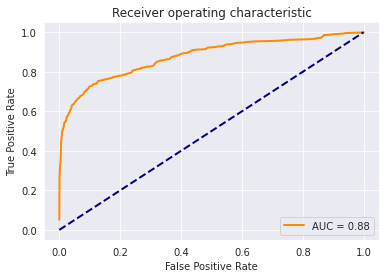

In [ ]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

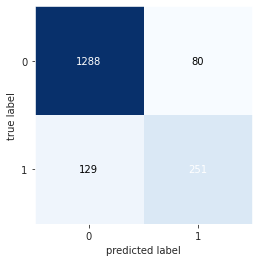

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

# Characteristics 